*refrensi*
https://www.kaggle.com/pablorosa01/naive-bayes-modeling-toxic-comments-jigsaw?scriptVersionId=80103579 

<div style="font-weight: bold;font-size:40px;background-color: #A0E8FF;padding:0 5%; color:#2F4F4F">Toxic Comments</div>

<center><img src="https://www.institutotraficoonline.com/wp-content/uploads/2021/02/haters-instituto-trafico-online-ito-roberto-gamboa.jpg" width=400></center>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Komentar *hater* bertebaran di sekitar kita, setiap saat di setiap jejaring sosial. Terima kasih kepada [Jigsaw](https://www.kaggle.com/c/jigsaw-toxic-severity-rating) karena telah mendorong kompetisi semacam ini agar internet yang jernih dapat meningkatkan metode moderasi kami.

Dalam notebook ini Anda akan pendekatan menggunakan classifier Navie Bayes karena ini adalah model yang sangat sederhana dengan sudut pandang statistik yang kuat.

Saya selalu berusaha membuat buku catatan sebaik mungkin, dan saya harap Anda juga menerimanya. <b>Jadi, jika menurut Anda menarik, UPVOTE kernel saya</b>
Anda mungkin tahu seberapa besar dampak positifnya terhadap pekerjaan kami sebagai ilmuwan data

Notebook ini membandingkan penggunaan *TF-IDF* dan *Non TF-IDF* pada model Machine Learning yang ada pada library *scikt-learn*:
1. Naive bayes
2. KNN
3. Neirest Neighbors
4. SVM
5. Stochastic Gradient Descent
6. Linear SVC
7. Neural Network

<h2>Imports</h2>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import progressbar
import nltk
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

import os

##Upload Datasets

In [3]:
TRAIN_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/text analytics/train.csv"
TEST_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/text analytics/comments_to_score.csv"
VALID_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/text analytics/validation_data.csv"
SAMPLE_SUBMISSION = "/content/drive/MyDrive/Colab Notebooks/text analytics/sample_submission.csv"

In [4]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)
df_validation_data = pd.read_csv(VALID_DATA_PATH)
df_sample_submission = pd.read_csv(SAMPLE_SUBMISSION)

#Pre Processing

In [5]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


##Function

In [6]:
def clean_phrases(phrase):
    """
    The aim of this function is to clear text following somme patterns.
    
    Args:
    phrase(str): String to be clean
    
    Return
    text(str): A cleaned phrase.
    
    """
    stop_words = stopwords.words('english')
    unewlevant_words = ['wiki','wikipedia','page']
    
    
    PATTERN = r'''(?x)                  # Flag para iniciar el modo verbose
                      (?:[A-Z]\.)+            # Hace match con abreviaciones como U.S.A.
                      | \w+(?:-\w+)*         # Hace match con palabras que pueden tener un guión interno
                      | \$?\d+(?:\.\d+)?%?  # Hace match con dinero o porcentajes como $15.5 o 100%
                      | \.\.\.              # Hace match con puntos suspensivos
                      | [][.,;"'?():-_`]    # Hace match con signos de puntuación
        '''

    word_token = nltk.regexp_tokenize(phrase, pattern= PATTERN)
    word_token = [palabra for palabra in word_token if len(palabra)>3 and palabra not in unewlevant_words and palabra not in stop_words]

    text = ''
    for _ in range(len(word_token)):
        text += word_token[_] + ' '
    
    return text



def document_features(document):
    
    """
    fungsi untuk memfilter teks berdasarkan aturan yang sudah ditentukan.
    
    Arg:
    
    document(str): berisikan teks yang akan difilter.
    
    Return
    features(dict) dict with word and boolean response if words contained exists.
    
    """
    
    document_words = set(document)
    features = {}
    for word in document_words:
        features['contains({})'.format(word)] = (word in document_words)
    return features


##Clean Text

gabungan dataset(train and test) untuk prediksi yang lebih baik

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
for _ in progressbar.progressbar(range(len(df_train))):
    phrase = df_train.loc[_,'comment_text']
    df_train.loc[_,'comment_text'] = clean_phrases(phrase).lower()
    
for _ in progressbar.progressbar(range(len(df_test))):
    phrase = df_test.loc[_,'text']
    df_test.loc[_,'text'] = clean_phrases(phrase).lower()

100% (159571 of 159571) |################| Elapsed Time: 0:37:00 Time:  0:37:00
100% (7537 of 7537) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


In [9]:
# Create a score that messure how much toxic is a comment
cat_mtpl = {'obscene': 0.16, 'toxic': 0.32, 'threat': 0.48, 
            'insult': 0.64, 'severe_toxic': 0.8, 'identity_hate': 1}

for category in cat_mtpl:
    df_train[category] = df_train[category] * cat_mtpl[category]

df_train['score'] = df_train.loc[:, 'toxic':'identity_hate'].sum(axis=1)

#Clases aren't balanced, that's whya a balance is needed
#Balance the clases
n_samples_toxic = len(df_train[df_train['score'] != 0])
n_samples_normal = len(df_train) - n_samples_toxic

idx_to_drop = df_train[df_train['score'] == 0].index[n_samples_toxic//5:]
df_train = df_train.drop(idx_to_drop)

print(f'Reduced number of neutral text samples from {n_samples_normal} to {n_samples_toxic//5}.')
print(f'Total number of training samples: {len(df_train)}')


Reduced number of neutral text samples from 143346 to 3245.
Total number of training samples: 19470


In [10]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,score
0,0000997932d777bf,explanation edits made username hardcore metal...,0.00,0.0,0.00,0.0,0.00,0,0.00
1,000103f0d9cfb60f,matches background colour seemingly stuck than...,0.00,0.0,0.00,0.0,0.00,0,0.00
2,000113f07ec002fd,really trying edit constantly removing relevan...,0.00,0.0,0.00,0.0,0.00,0,0.00
3,0001b41b1c6bb37e,more make real suggestions improvement wondere...,0.00,0.0,0.00,0.0,0.00,0,0.00
4,0001d958c54c6e35,hero chance remember,0.00,0.0,0.00,0.0,0.00,0,0.00
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,previous conversation fucking shit eating libe...,0.32,0.0,0.16,0.0,0.64,1,2.12
159514,ff39a2895fc3b40e,mischievious pubic hair,0.32,0.0,0.00,0.0,0.64,0,0.96
159541,ffa33d3122b599d6,your absurd edits your absurd edits great whit...,0.32,0.0,0.16,0.0,0.64,0,1.12
159546,ffb47123b2d82762,listen ever delete edits ever annoyed 2k15 ros...,0.32,0.0,0.00,0.0,0.64,0,0.96


#EDA

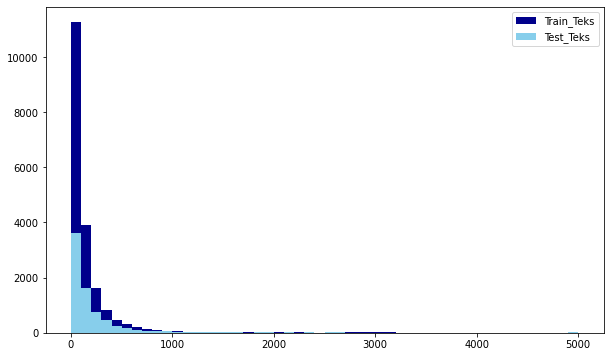

In [12]:
length_train = df_train['comment_text'].str.len()
length_test = df_test['text'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="Train_Teks", color="darkblue")
plt.hist(length_test, bins=50, label="Test_Teks", color = "skyblue")
plt.legend()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19470 entries, 0 to 159554
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19470 non-null  object 
 1   comment_text   19470 non-null  object 
 2   toxic          19470 non-null  float64
 3   severe_toxic   19470 non-null  float64
 4   obscene        19470 non-null  float64
 5   threat         19470 non-null  float64
 6   insult         19470 non-null  float64
 7   identity_hate  19470 non-null  int64  
 8   score          19470 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.5+ MB


In [12]:
df_train.isnull()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,score
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
159494,False,False,False,False,False,False,False,False,False
159514,False,False,False,False,False,False,False,False,False
159541,False,False,False,False,False,False,False,False,False
159546,False,False,False,False,False,False,False,False,False


In [16]:
df_train.isnull().count()

id               19470
comment_text     19470
toxic            19470
severe_toxic     19470
obscene          19470
threat           19470
insult           19470
identity_hate    19470
score            19470
dtype: int64

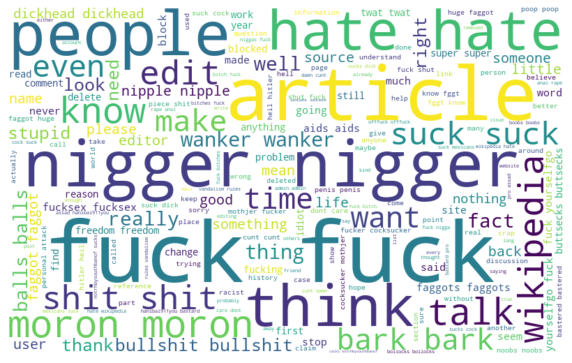

In [13]:
#data pada data train
def wordCloud(words):
  wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

  plt.figure(figsize=(10, 7))
  plt.imshow(wordCloud, interpolation='bilinear')
  plt.axis('off')

all_words = ''.join([text for text in df_train['comment_text']])
wordCloud(all_words)

#Feature Engineering

In [14]:
#Feature engineering for creating 
df_tragets = pd.DataFrame(pd.unique(df_train['score'].values), columns=['target_value']).sort_values(by='target_value', ascending = True).reset_index(drop=True)
THRESHOLD = df_tragets['target_value'].quantile(q=0.2)
df_train['sentiment'] = df_train['score'].map(lambda x: 1 if x < THRESHOLD else 2 if x < THRESHOLD*2 else 3 if x < THRESHOLD*3 else 4 if x < THRESHOLD*4 else 5)

df_train = df_train[['comment_text','sentiment']].reset_index(drop=True)
df_train

,comment_text,sentiment
0,explanation edits made username hardcore metal...,1
1,matches background colour seemingly stuck than...,1
2,really trying edit constantly removing relevan...,1
3,more make real suggestions improvement wondere...,1
4,hero chance remember,1
...,...,...
19465,previous conversation fucking shit eating libe...,3
19466,mischievious pubic hair,2
19467,your absurd edits your absurd edits great whit...,2
19468,listen ever delete edits ever annoyed 2k15 ros...,2


In [15]:
df_train.groupby(by='sentiment').count()

,comment_text
sentiment,
1,11605
2,5687
3,1882
4,296


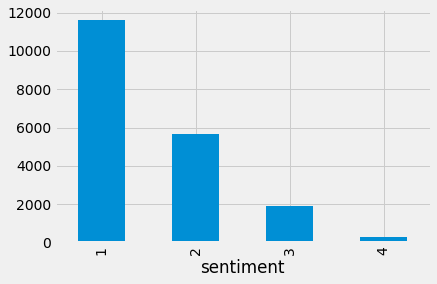

In [370]:
df_train.groupby('sentiment').size().plot(kind='bar')

##TF-IDF

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf=True)

train_vectorizer = vectorizer.fit_transform(df_train['comment_text'])
test_vectorizer = vectorizer.transform(df_test['text'])

#Modelling

In [259]:
bayes = []
knn = []
nn = []
svc = []
neirest = []
stochastic = []
svma = []
dt = []

##Non TF-IDF

In [260]:
df_train = df_train.reset_index(drop=True)
df_train_1 = df_train[:15576]
df_train_2 = df_train[15576:].reset_index(drop=True)

In [348]:
vectorizer_non = CountVectorizer()
counts = vectorizer_non.fit_transform(df_train_1['comment_text'].values)

### Naive Bayes

In [262]:
classifier = MultinomialNB()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

MultinomialNB()

In [263]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([3])

In [264]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,2
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,2
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,2
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [265]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
bayes.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5916795069337443


###KNN

In [266]:
vectorizer_non = CountVectorizer()
counts = vectorizer_non.fit_transform(df_train_1['comment_text'].values)

In [267]:
from sklearn.neighbors import KNeighborsClassifier

In [268]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([3])

In [269]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,2
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,2
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,2
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [270]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
knn.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5916795069337443


###Decision Tree

In [271]:
from sklearn import tree

In [272]:
classifier = tree.DecisionTreeClassifier()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

DecisionTreeClassifier()

In [273]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [274]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,3
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,2
3892,listen ever delete edits ever annoyed 2k15 ros...,2,1


In [275]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
dt.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5490498202362609


###SVM

In [276]:
from sklearn import svm

In [351]:
classifier = svm.SVC()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

SVC()

In [352]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([1])

In [353]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,1


In [354]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
svma.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5441705187467899


###Stochastic Gradient Descent


In [281]:
from sklearn.linear_model import SGDClassifier

In [282]:
classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

SGDClassifier(max_iter=5)

In [283]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [284]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,3
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,2
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [285]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
stochastic.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5359527478171546


###Neirest Neighbors

In [286]:
from sklearn.neighbors import NearestCentroid

In [287]:
classifier = NearestCentroid()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

NearestCentroid()

In [288]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([1])

In [289]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,3
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,3
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [290]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
neirest.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5659989727786338


###Linear SVC

In [291]:
from sklearn.svm import LinearSVC

In [292]:
classifier = LinearSVC(random_state=0)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

LinearSVC(random_state=0)

In [293]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [294]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,3
3890,mischievious pubic hair,2,2
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [295]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
svc.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5693374422187981


###Neural Network

In [296]:
from sklearn.neural_network import MLPClassifier

In [297]:
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [298]:
#Example
example = ['mother fucker']
example_counts = vectorizer_non.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [299]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer_non.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,2
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [300]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
nn.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5842321520287622


##TF-IDF

In [301]:
df_train = df_train.reset_index(drop=True)
df_train_1 = df_train[:15576]
df_train_2 = df_train[15576:].reset_index(drop=True)

In [355]:
counts = vectorizer.fit_transform(df_train_1['comment_text'].values)

### Naive Bayes

In [303]:
classifier = MultinomialNB()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

MultinomialNB()

In [304]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [305]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,1
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,1


In [306]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
bayes.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5983564458140729


###KNN

In [307]:
from sklearn.neighbors import KNeighborsClassifier

In [308]:
classifier = KNeighborsClassifier(n_neighbors=3)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

KNeighborsClassifier(n_neighbors=3)

In [309]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [310]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,1
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,1
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,1


In [311]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
knn.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.536723163841808


###Decision Tree

In [312]:
from sklearn import tree

In [313]:
classifier = tree.DecisionTreeClassifier()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

DecisionTreeClassifier()

In [314]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [315]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,3
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,2
3892,listen ever delete edits ever annoyed 2k15 ros...,2,1


In [316]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
dt.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5662557781201849


###SVM

In [317]:
from sklearn import svm

In [356]:
classifier = svm.SVC()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

SVC()

In [357]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [358]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,3
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [359]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
svma.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6366204417051875


###Stochastic Gradient Descent


In [322]:
from sklearn.linear_model import SGDClassifier

In [323]:
classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

SGDClassifier(max_iter=5)

In [324]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([3])

In [325]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,3
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [326]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
stochastic.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6212121212121212


###Neirest Neighbors

In [327]:
from sklearn.neighbors import NearestCentroid

In [328]:
classifier = NearestCentroid()
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

NearestCentroid()

In [329]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([3])

In [330]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,3
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,3
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,2
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [331]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
neirest.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5834617360041089


###Linear SVC

In [332]:
from sklearn.svm import LinearSVC

In [333]:
classifier = LinearSVC(random_state=0)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

LinearSVC(random_state=0)

In [334]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([3])

In [335]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,3
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,2


In [336]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
svc.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6076014381099127


###Neural Network

In [337]:
from sklearn.neural_network import MLPClassifier

In [338]:
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
targets = df_train_1['sentiment'].values

classifier.fit(counts, targets)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [339]:
#Example
example = ['mother fucker']
example_counts = vectorizer.transform(example)

prediction = classifier.predict(example_counts)
prediction

array([2])

In [340]:
df_train_2['vectorizer'] = df_train_2['comment_text'].map(lambda x: vectorizer.transform([x]))
df_train_2['prediction'] = df_train_2['vectorizer'].map(lambda x: classifier.predict(x)[0])
df_train_2[['comment_text','sentiment','prediction']]

,comment_text,sentiment,prediction
0,intimidation would fucking piggy face people p...,4,2
1,from someone totally wronged bullshit managed ...,1,1
2,joking welcomed athenian politely albanian wik...,1,1
3,idiots always demand explain talk pages always...,2,1
4,jehovah witnesses bunch cultish freaks need ah...,1,1
...,...,...,...
3889,previous conversation fucking shit eating libe...,3,2
3890,mischievious pubic hair,2,1
3891,your absurd edits your absurd edits great whit...,2,1
3892,listen ever delete edits ever annoyed 2k15 ros...,2,1


In [341]:
y_test = df_train_2[['sentiment']]
y_pred = df_train_2[['prediction']]
nn.append(metrics.accuracy_score(y_test, y_pred))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5772984078068824


#Hasil

In [378]:
import pandas as pd
modeltfidf = pd.DataFrame(index=['non-tfidf', 'tfidf'])
modeltfidf['naive_bayes'] = bayes
modeltfidf['knn'] = knn
modeltfidf['neural_network'] = nn
modeltfidf['linear_svc'] = svc
modeltfidf['neirest_neighbors'] = neirest
modeltfidf['stochastic_Gradient_Descent'] = stochastic
modeltfidf['svm'] = svma
modeltfidf['decision_tree'] = dt

In [363]:
modeltfidf

,naive_bayes,knn,neural_network,linear_svc,neirest_neighbors,stochastic_Gradient_Descent,svm,decision_tree
non-tfidf,0.591680,0.591680,0.584232,0.569337,0.565999,0.535953,0.544171,0.549050
tfidf,0.598356,0.536723,0.577298,0.607601,0.583462,0.621212,0.636620,0.566256


[Text(0, 0, 'non-tfidf'), Text(0, 0, 'tfidf')]

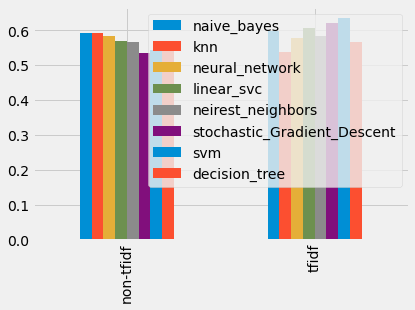

In [379]:
ax = modeltfidf.plot.bar()

ticks = [tick.get_text() for tick in ax.get_xticklabels()]
#ticks = pd.to_datetime(ticks).strftime('%b %Y')
ax.set_xticklabels(ticks)

Transpose

In [380]:
modeltfidf = modeltfidf.T

In [382]:
modeltfidf

,non-tfidf,tfidf
naive_bayes,0.591680,0.598356
knn,0.591680,0.536723
neural_network,0.584232,0.577298
linear_svc,0.569337,0.607601
neirest_neighbors,0.565999,0.583462
stochastic_Gradient_Descent,0.535953,0.621212
svm,0.544171,0.636620
decision_tree,0.549050,0.566256


[Text(0, 0, 'naive_bayes'),
 Text(0, 0, 'knn'),
 Text(0, 0, 'neural_network'),
 Text(0, 0, 'linear_svc'),
 Text(0, 0, 'neirest_neighbors'),
 Text(0, 0, 'stochastic_Gradient_Descent'),
 Text(0, 0, 'svm'),
 Text(0, 0, 'decision_tree')]

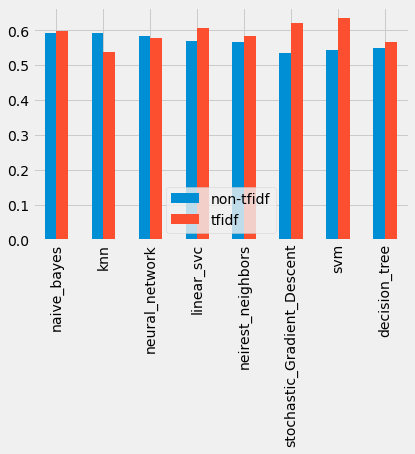

In [381]:
ax = modeltfidf.plot.bar()

ticks = [tick.get_text() for tick in ax.get_xticklabels()]
#ticks = pd.to_datetime(ticks).strftime('%b %Y')
ax.set_xticklabels(ticks)